## Niwot Species Distribution Models
### Aaron Westmoreland, Michael Catchen, Will Reed(?)
---


## I. Introduction

- What did we do (multilevel species dist models) 
- What data do we have (a lot)
- What questions did we answer (none to very few)
- How did we do/not do it (stan)
- What big words can we look forward to hearing in the next 20 minutes? (Bayesian multilevel models, Hamiltonian Monte Carlo)
- Can we say anything about the world based on this analysis? (kinda)
- Can we predict anything about the world based on this analysis? (fat chance, buster)

## II. The Data

#### Load Libraries

In [1]:
# run devtools::install_github("rmcelreath/rethinking") from rstudio
reqs = c("tidyverse", "Rcpp", "rstan", "mvtnorm", "rethinking", "coda","mvtnorm","devtools","loo","dagitty", "rethinking")
loaded_reqs = lapply(reqs, require, character.only=T)

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Rcpp

Loading required package: rstan

Loading required package: StanHeaders

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: mvtnorm

Loading required package: rethinking

Loading required package: pa

#### Load Helper Functions

In [8]:
source('./src/loading_data.R')
source('./src/simulate_data.R')

#### Load Data

In [9]:
composition_data = load_data()

## III. Models

### Simulating Fake Data to Test Models 

We want to simluate dataframes that (essentially) look like

| time | species | cover | presence | plot | subplot | abiotic var 1 | abiotic var 2 | abiotic var 3 |
|------|---------|-------|----------|------|---------|---------------|---------------|---------------|
| -    | -       | -     | -        | -    | -       | -             | -             | -             |
| -    | -       | -     | -        | -    | -       | -             | -             | -             |

We do this with the following

In [10]:
source('./src/simulate_data.R')
fake_data = simulate_data(n_species=1, n_abiotic_vars=2, n_plots=40)

df = fake_data$df

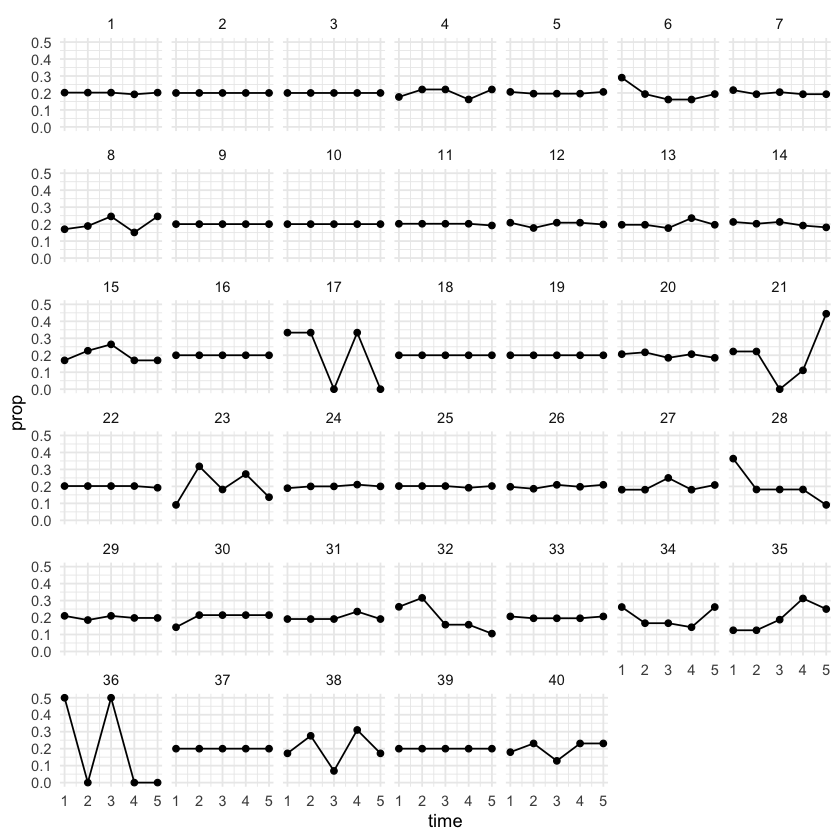

In [11]:
prop = df  %>% group_by(plt,time) %>% summarize(pres_ct = sum(presence)) %>% mutate(total = sum(pres_ct), prop = pres_ct / total)
prop %>% ggplot(aes(time, prop)) + geom_line() + geom_point() + facet_wrap(. ~ plt) + theme_minimal() 

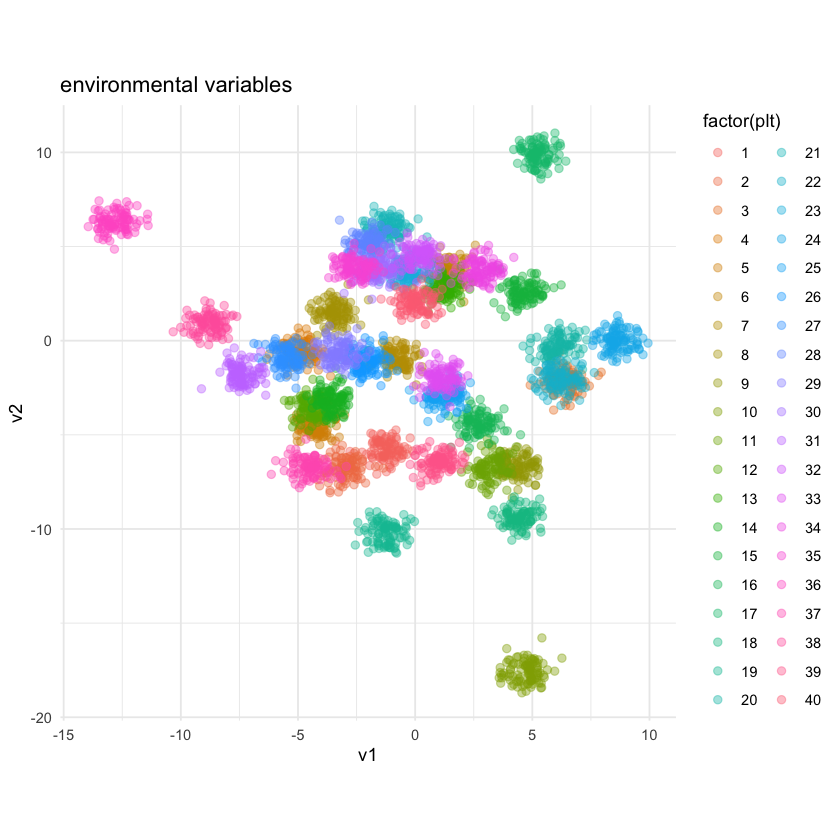

In [12]:
df %>% group_by(plt,time) %>% ggplot(aes(v1, v2, color=factor(plt))) + geom_jitter(height=0.05, width=0, size=2, alpha=0.4) + theme_minimal() + theme(aspect.ratio=1) + labs(title='environmental variables')

In [13]:
glimpse(fake_data$true_values)

List of 3
 $ alpha            : num 1.31
 $ beta             : num [1:2] 0.166 -0.651
 $ ef_covariance_mat: num [1:2, 1:2] 0.3742 -0.0962 -0.0962 0.1203


### Simplest Model

Total pooling.

$$S_i \sim Bernoulli(p_i) \quad\quad \text{likelihood}$$

$$\text{logit}(p_i) = \alpha \quad\quad \text{link}$$

$$\alpha \sim \text{N}(0,0.5)$$

In [10]:
total_pooling = map2stan(
    # model definition
    alist(
        presence ~ dbinom(1, p),
        logit(p) <- a + beta_1*v1 + beta_2*v2 ,
        beta_1 ~ dnorm(0,5),
        beta_2 ~ dnorm(0,5),
        a ~ dnorm( 0, 5 )
    ),
    data=fake_data$df)
post = extract.samples(total_pooling)
glimpse(post)


SAMPLING FOR MODEL '9237af6dfd3012413e8679f12997787d' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001529 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 15.29 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 6.40498 seconds (Warm-up)
Chain 1:                5.60233 seconds (Sampling)


Computing WAIC



List of 3
 $ beta_1: num [1:1000(1d)] -0.0371 -0.033 -0.0411 -0.0432 -0.0353 ...
 $ beta_2: num [1:1000(1d)] 0.331 0.333 0.359 0.356 0.365 ...
 $ a     : num [1:1000(1d)] 0.05 0.062 0.0221 -0.0816 0.0359 ...


-0.04545346,0.7714545
0.77145448,0.1016468


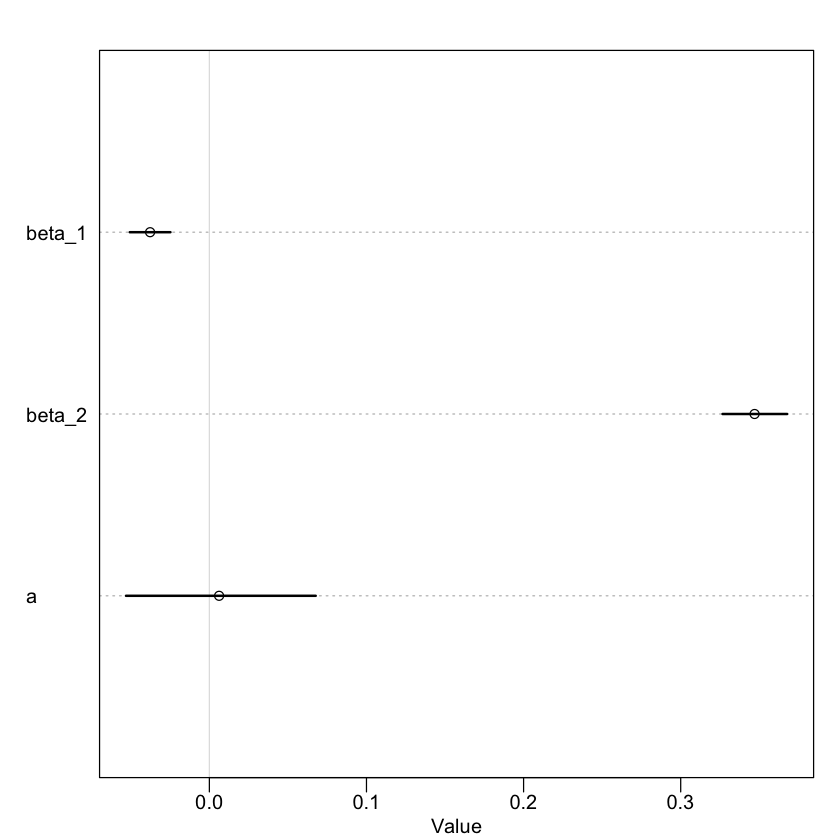

In [26]:
fake_data$true_values
plot(precis(total_pooling,depth=2)) # also plot

#### Varying Intercepts

In [27]:
varying_intercepts = map2stan(
    # model definition
    alist(
        presence ~ dbinom(1, p),
        logit(p) <- a[plt] + beta_1*v1 + beta_2*v2,
        beta_1 ~ dnorm(0,1),
        beta_2 ~ dnorm(0,1),
        a_mean ~ dnorm(0,1),
        a_var ~ dnorm(0, 3),
        a[plt] ~ dnorm( a_mean, a_var )
    ),
    data=fake_data$df)
post = extract.samples(varying_intercepts)
glimpse(post)


SAMPLING FOR MODEL '6c52dd05a3780823991c777d089b88e6' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001556 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 15.56 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 51.323 seconds (Warm-up)
Chain 1:                29.7501 seconds (Sampling)
C

Warning message:
“There were 6 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”
Computing WAIC

Warning message in map2stan(alist(presence ~ dbinom(1, p), logit(p) <- a[plt] + :
“There were 6 diverge

List of 5
 $ beta_1: num [1:1000(1d)] -0.687 -0.684 -0.742 -0.695 -0.662 ...
 $ beta_2: num [1:1000(1d)] 0.719 0.725 0.78 0.728 0.718 ...
 $ a_mean: num [1:1000(1d)] 0.313 0.357 0.646 0.269 0.424 ...
 $ a_var : num [1:1000(1d)] 0.0288 0.1952 0.1837 0.1538 0.2707 ...
 $ a     : num [1:1000, 1:40] 0.327 0.109 0.508 0.425 0.455 ...


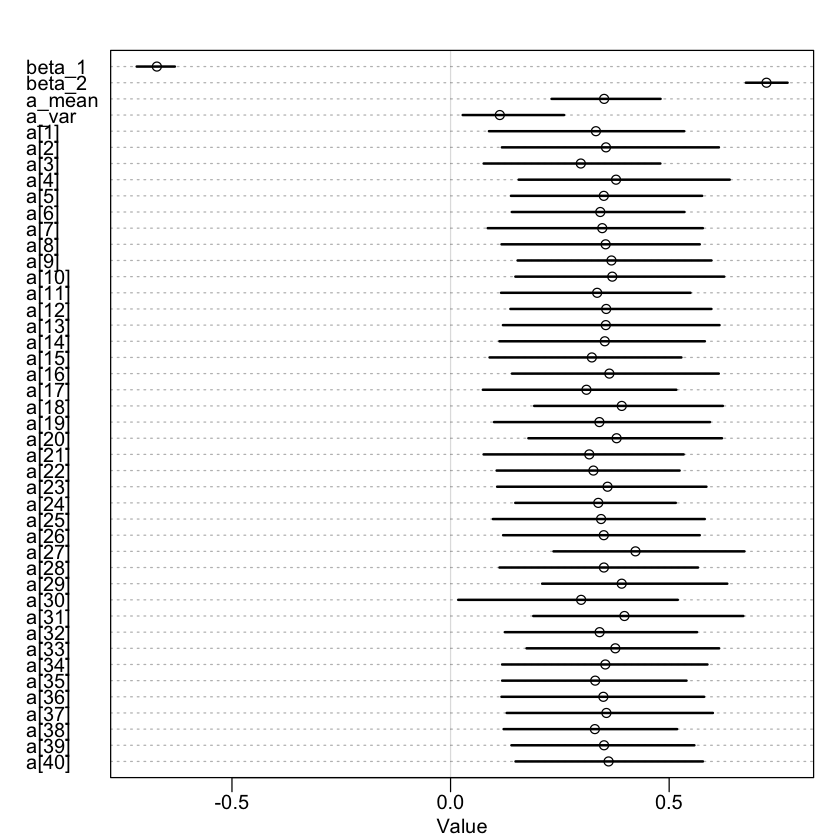

In [28]:
plot(precis(varying_intercepts,depth=2)) # also plot